# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified deterministic model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

### Load required packages

In [1]:
import random
import os
import numpy as np
import json
import corner
import random

import pandas as pd
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt
import datetime

from covid19model.visualization.output import _apply_tick_locator
from covid19model.optimization import objective_fcns, pso
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## Load data and initialize model

### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
levels = initN.size

### Scrape high-level Sciensano data

In [3]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-10-29,6187,1057,673,474,4738,132,1.0,7.0,19,49,56
2020-10-30,6438,1105,720,463,4995,160,0.0,11.0,16,67,66
2020-10-31,6501,1161,684,657,5022,120,1.0,7.0,24,42,46
2020-11-01,6823,1223,555,250,5327,98,0.0,10.0,21,31,36
2020-11-02,7231,1302,596,180,5743,26,0.0,3.0,7,9,7


### Initialize the model without time-dependent parameters

In [4]:
from covid19model.models.utils import draw_sample_COVID19_SEIRD, lockdown_func

In [5]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
               'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': pd.to_datetime('2020-03-15')})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

## Perform calibration

In [8]:
# Date of first data collection
start_date = '2020-03-15'
# Last datapoint used to calibrate basic reproduction number
end_beta = '2020-03-25'
# Last datapoint used to calibrate the compliance ramp
end_ramp = '2020-05-01'
# Path where figures should be stored
fig_path = '../results/calibrations/COVID19_SEIRD/national/'
# Path where MCMC samples should be saved
samples_path = '../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'
# Spatial unit: Belgium
spatial_unit = 'BE'

In [8]:
from covid19model.optimization.run_optimization import full_calibration_wave1
samples_dict = full_calibration_wave1(model, df_sciensano['H_in'], spatial_unit, start_date, end_beta, end_ramp, 
                                fig_path=fig_path, samples_path=samples_path,
                                initN=initN, Nc_total=Nc_total,
                                maxiter=50, popsize=50, steps_mcmc=500, discard=200)

---------------------------
CALIBRATING BETA AND WARMUP
---------------------------

1) Particle swarm optimization

No constraints given.
Best after iteration 1: [7.08628043e+01 5.09907089e+01 3.81795046e-02] 50.195229887303434
Best after iteration 2: [7.08628043e+01 5.09907089e+01 3.81795046e-02] 50.195229887303434
New best for swarm at iteration 3: [5.41558726e+01 5.15984643e+01 3.75150998e-02] 49.462976345104494
Best after iteration 3: [5.41558726e+01 5.15984643e+01 3.75150998e-02] 49.462976345104494
New best for swarm at iteration 4: [5.84270015e+01 4.79187472e+01 4.00000000e-02] 49.30055497715698
Best after iteration 4: [5.84270015e+01 4.79187472e+01 4.00000000e-02] 49.30055497715698
Best after iteration 5: [5.84270015e+01 4.79187472e+01 4.00000000e-02] 49.30055497715698
New best for swarm at iteration 6: [5.71909215e+01 5.40135086e+01 3.61445657e-02] 49.29945210347534
Best after iteration 6: [5.71909215e+01 5.40135086e+01 3.61445657e-02] 49.29945210347534
Best after iteration 7:

  0%|          | 0/500 [00:00<?, ?it/s]

Best after iteration 50: [5.27846347e+01 5.07059493e+01 3.79726045e-02] 49.12012291835732
Stopping search: maximum iterations reached --> 50

2) Markov-Chain Monte-Carlo sampling



100%|██████████| 500/500 [01:15<00:00,  6.60it/s]


Use this estimate with caution and run a longer chain!
---------------------------------------------------------------------------------------------------------

CALIBRATING COMPLIANCE RAMP
---------------------------

1) Particle swarm optimization


2) Markov-Chain Monte-Carlo sampling

No constraints given.
Best after iteration 1: [48.28398563  7.83336187  2.05030532  0.37228377] 212.55422099731692
Best after iteration 2: [48.28398563  7.83336187  2.05030532  0.37228377] 212.55422099731692
Best after iteration 3: [48.28398563  7.83336187  2.05030532  0.37228377] 212.55422099731692
Best after iteration 4: [48.28398563  7.83336187  2.05030532  0.37228377] 212.55422099731692
Best after iteration 5: [48.28398563  7.83336187  2.05030532  0.37228377] 212.55422099731692
Best after iteration 6: [48.28398563  7.83336187  2.05030532  0.37228377] 212.55422099731692
Best after iteration 7: [48.28398563  7.83336187  2.05030532  0.37228377] 212.55422099731692
Best after iteration 8: [48.28398563 

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/pool.py", line 689, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/pool.py", line 674, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt: 
Process ForkPoolWorker-17:
Process ForkPoolWorker-16:
Process ForkPoolWorker-20:
Process ForkPoolWorker-19:
Process ForkPoolWorker-18:
Process ForkPoolWorker-22:
Traceback (most recent call last):
Process ForkPoolWorker-15:
Process ForkPoolWorker-12:
Process ForkPoolWorker-21:
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call

  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
Process ForkPoolWorker-14:
Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/twallema/anaconda3/envs/COVID_MODEL

---------------------------------------------------------------------------------------------------------

DONE

SAMPLES DICTIONARY SAVED IN "../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_2020-11-05.json"


## Visualize fit

### $\beta$

<ipython-input-9-9fed7268649a>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/BETA.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


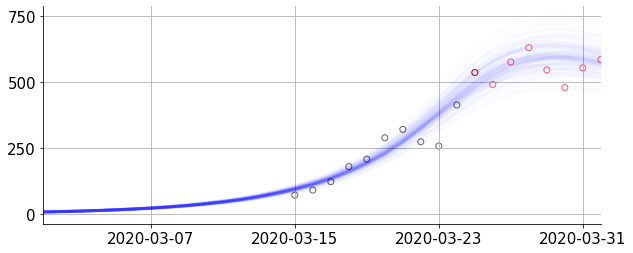

In [9]:
end_sim = '2020-04-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(100):
    model.parameters = draw_sample_COVID19_SEIRD(model.parameters,samples_dict,beta_only=False)
    y_model = model.sim(end_sim,start_date=start_date,excess_time=samples_dict['warmup'])
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.01)

ax.scatter(df_sciensano[:end_beta].index,df_sciensano['H_in'][:end_beta],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax.scatter(df_sciensano[end_beta:end_sim].index,df_sciensano['H_in'][end_beta:end_sim],color='red',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-03-01',end_sim)

plt.savefig(fig_path+'others/BETA.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### $R_0$

<ipython-input-10-7c3c253d16fa>:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/R0.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


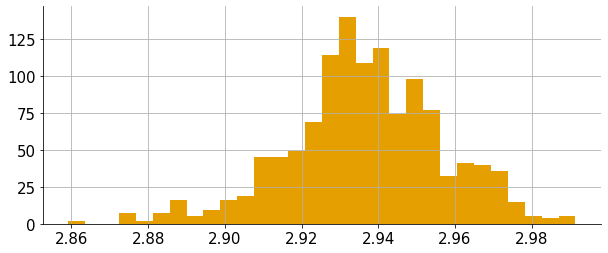

In [10]:
fig,ax=plt.subplots(figsize=(10,4))
ax.hist(samples_dict['R0'],bins=30)
plt.savefig(fig_path+'others/R0.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### $l$ and $\tau$

<ipython-input-11-3457d83673a0>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/RAMP.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


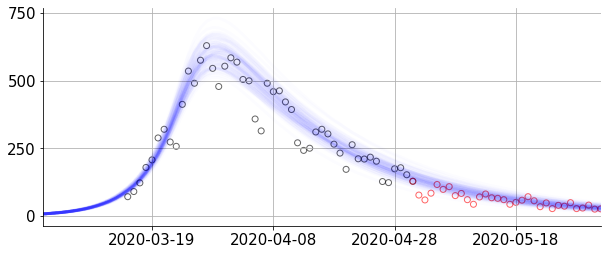

In [11]:
end_sim = '2020-06-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(100):
    model.parameters = draw_sample_COVID19_SEIRD(model.parameters,samples_dict,beta_only=False)
    y_model = model.sim(end_sim,start_date=start_date,excess_time=samples_dict['warmup'])
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.01)

ax.scatter(df_sciensano[:end_ramp].index,df_sciensano['H_in'][:end_ramp],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax.scatter(df_sciensano[end_ramp:end_sim].index,df_sciensano['H_in'][end_ramp:end_sim],color='red',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-03-01',end_sim)

plt.savefig(fig_path+'others/RAMP.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

## Other visualisations used in the preprint

### Load the posterior samples

In [6]:
# Load previous samples
with open('../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_2020-11-05.json', 'r') as fp:
    samples_dict = json.load(fp)

### Seroprelevance

<ipython-input-12-0b1275836fcd>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/SEROPRELEVANCE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


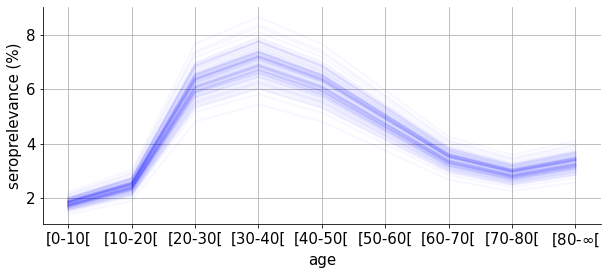

In [12]:
end_sim = '2020-06-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(100):
    model.parameters = draw_sample_COVID19_SEIRD(model.parameters,samples_dict,beta_only=False)
    y_model = model.sim(end_sim,start_date=start_date,excess_time=samples_dict['warmup'])
    ax.plot((1-y_model["S"].sel(time=end_sim)/y_model["S"].isel(time=0))*100,alpha=0.03,color='blue',linewidth=2)

ax.set_xlabel('age')
ax.set_ylabel("seroprelevance (%)" )
ax.set_ylim()
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))

plt.savefig(fig_path+'others/SEROPRELEVANCE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### Cumulative hospitalisations vs. $R_0$

<ipython-input-13-51c97992e368>:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/HOSP_R0.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


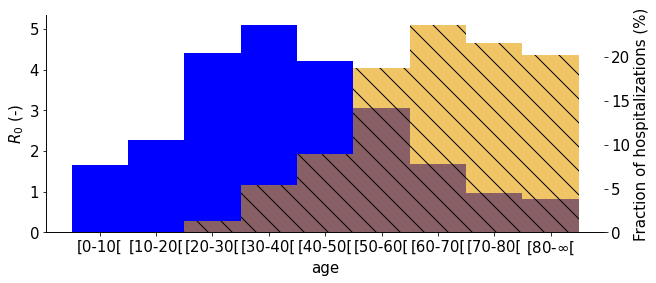

In [13]:
end_sim = '2020-06-01'
n=10

csum_save=np.zeros([n,9])
for i in range(n):
    model.parameters = draw_sample_COVID19_SEIRD(model.parameters,samples_dict,beta_only=False)
    y_model = model.sim(end_sim,start_date=start_date,excess_time=samples_dict['warmup'])
    csum_iplus = y_model['H_in'].cumsum(dim="time")[:,-1].values
    csum_save[i,:]=np.reshape((csum_iplus/sum(csum_iplus)),(1,(csum_iplus/sum(csum_iplus)).size))*100
    
csum_hosp_mean = csum_save.mean(axis=0)
csum_hosp_p10 = np.percentile(csum_save,10,axis=0)
csum_hosp_p90 = np.percentile(csum_save,90,axis=0)

R0_age = []
for key in samples_dict['R0_stratified_dict']:
    R0_age.append(np.mean(samples_dict['R0_stratified_dict'][key]))


fig,ax1=plt.subplots()

ax1.bar(np.arange(9),R0_age,1,color='blue')
ax1.set_xlabel('age')
ax1.set_ylabel('$R_0$ (-)')
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(np.arange(9),csum_hosp_mean,1,alpha=0.6,hatch="\\")
ax2.set_xlabel('age')
ax2.set_ylabel('Fraction of hospitalizations (%)')
ax2.grid(False)
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))

fig.set_size_inches(10, 4)
plt.savefig(fig_path+'others/HOSP_R0.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### Lockdown release

In [14]:
from covid19model.models.utils import policies_until_september

In [52]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy2': 1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.15)*Nc_others + (1-0.85)*Nc_schools + (1-0.50)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.10)*Nc_others + (1-0.35)*Nc_schools + (1-0.30)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure,
               'policy8': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure,
               'policy9': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure,
               'l': np.mean(samples_dict['l']),
              'tau': np.mean(samples_dict['tau']),
              'prevention': np.mean(samples_dict['prevention']),
              'start_date': pd.to_datetime('2020-03-15')})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': policies_until_september})

<ipython-input-53-18e22ced77c3>:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/lockdown_release.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


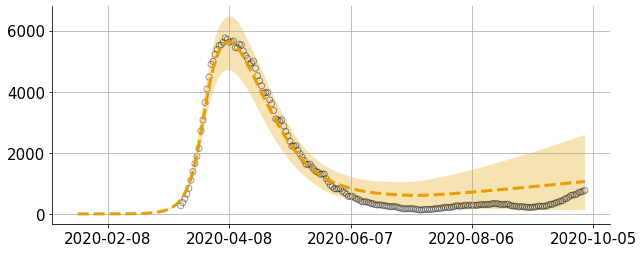

In [53]:
end_sim = '2020-10-01'
n=100
percentile = 0.99

y_model = model.sim(end_sim,start_date=start_date,excess_time=samples_dict['warmup'],N=n,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model['time'].values),y_model["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), y_model["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(y_model['time'],y_model["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.scatter(df_sciensano[:end_sim].index,df_sciensano['H_tot'][:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
plt.savefig(fig_path+'others/lockdown_release.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### Continuation of lockdown

In [54]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

lockdown_policy = 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure
params.update({'policy0': Nc_total,
              'policy1': lockdown_policy,
              'policy2': lockdown_policy,
              'policy3': lockdown_policy,
              'policy4': lockdown_policy,
              'policy5': lockdown_policy,
              'policy6': lockdown_policy,
              'policy7': lockdown_policy,
              'policy8': lockdown_policy,
              'policy9': lockdown_policy,
              'l': np.mean(samples_dict['l']),
              'tau': np.mean(samples_dict['tau']),
              'prevention': np.mean(samples_dict['prevention']),
              'start_date': pd.to_datetime('2020-03-15')})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': policies_until_september})

<ipython-input-55-55bdf8f32f09>:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/continued_lockdown.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


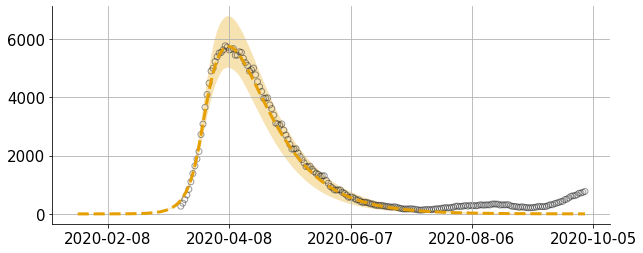

In [55]:
end_sim = '2020-10-01'
n=100
percentile = 0.99

y_model = model.sim(end_sim,start_date=start_date,excess_time=samples_dict['warmup'],N=n,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model['time'].values),y_model["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), y_model["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(y_model['time'],y_model["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.scatter(df_sciensano[:end_sim].index,df_sciensano['H_tot'][:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
plt.savefig(fig_path+'others/continued_lockdown.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### (Legacy) Re-estimating beta

In [50]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [51]:
def beta_reestimate_func(t,param,change_beta_time,beta_old,beta_new):
    if t <= change_beta_time:
        return beta_old
    elif change_beta_time < t <= change_beta_time+120:
        return beta_new
    else:
        return beta_new

In [52]:
# Load previous samples
with open('../data/interim/model_parameters/deterministic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'r') as fp:
    samples_dict = json.load(fp)

In [53]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Add all time-dependent parameters to function definition
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': samples_dict['lag_time'],
              'l': np.mean(samples_dict['l']),
              'tau': np.mean(samples_dict['tau']),
              'prevention': np.mean(samples_dict['prevention']),
               'change_beta_time': np.mean(samples_dict['lag_time'])+50,
               'beta_old': np.mean(samples_dict['beta']),
               'beta_new': 0.06})
# Initialise the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func, 'beta': beta_reestimate_func})

In [54]:
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
model.parameters['prevention'] = np.mean(samples_dict['prevention'])

In [55]:
T = 62
from copy import deepcopy
# define dataset
data=[df_sciensano["H_in"].values[:]]
# Redine lag_time
model.extraTime = samples_dict['lag_time']
# define samples_dict without lag_time
smpls=deepcopy(samples_dict)
del smpls['lag_time']
# set optimisation settings
parNames = ['sigma_H_in','beta_new'] # must be a list!
states = [["H_in"]]
bounds=((1,500),(0.001,0.06)) # must be a list!

In [56]:
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,samples=smpls,maxiter=50,popsize=20)

No constraints given.
New best for swarm at iteration 1: [1.03223564e+02 5.52694162e-02] 967.415155835764
Best after iteration 1: [1.03223564e+02 5.52694162e-02] 967.415155835764
New best for swarm at iteration 2: [5.72996498e+01 1.00000000e-03] 891.4818397745754
Best after iteration 2: [5.72996498e+01 1.00000000e-03] 891.4818397745754
Best after iteration 3: [5.72996498e+01 1.00000000e-03] 891.4818397745754
Best after iteration 4: [5.72996498e+01 1.00000000e-03] 891.4818397745754
Best after iteration 5: [5.72996498e+01 1.00000000e-03] 891.4818397745754
New best for swarm at iteration 6: [5.86143298e+01 1.00000000e-03] 879.185014520443
Best after iteration 6: [5.86143298e+01 1.00000000e-03] 879.185014520443
New best for swarm at iteration 7: [5.42044761e+01 1.00000000e-03] 872.1476922846537
Best after iteration 7: [5.42044761e+01 1.00000000e-03] 872.1476922846537
Best after iteration 8: [5.42044761e+01 1.00000000e-03] 872.1476922846537
Best after iteration 9: [5.42044761e+01 1.00000000

In [57]:
parNames = ['sigma_ICU','beta_new'] # must be a list!
bounds=((1,200),(0.0001,0.20))

pos = [theta[0],theta[1]] + [1, 1e-2 ]* np.random.randn(8, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,smpls))
sampler.run_mcmc(pos, 1000, progress=True);

  0%|          | 0/500 [00:00<?, ?it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [05:11<00:00,  1.60it/s]


In [58]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [59]:
# Calculate the autocorrelation time
try:
    print(sampler.get_autocorr_time())
except:
    print('The chain is shorter than 50 times the integrated autocorrelation time.')

The chain is shorter than 50 times the integrated autocorrelation time.


In [60]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.06035435457147051 0.05706839312423164 0.06325335615126233


In [61]:
samples_dict.update({'beta_new': flat_samples[:,1].tolist()})

In [62]:
with open('../data/interim/model_parameters/deterministic_'+ datetime.datetime.today().strftime('%Y-%m-%d')+'.json', 'w') as fp:
    json.dump(samples_dict, fp)

<AxesSubplot:xlabel='step number', ylabel='beta_new'>

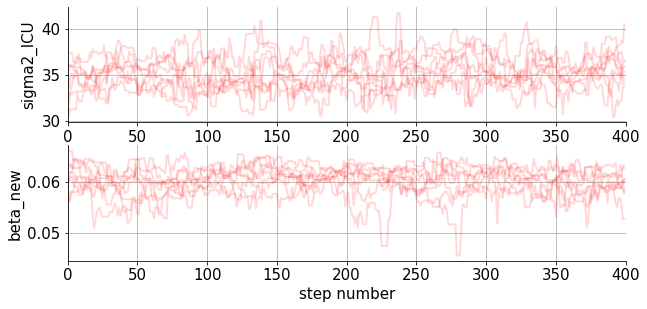

In [63]:
traceplot(samples,labels=["sigma2_ICU","beta_new"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

<ipython-input-64-3a2dc3afe2ca>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/corner_beta.pdf', dpi=600, bbox_inches='tight',


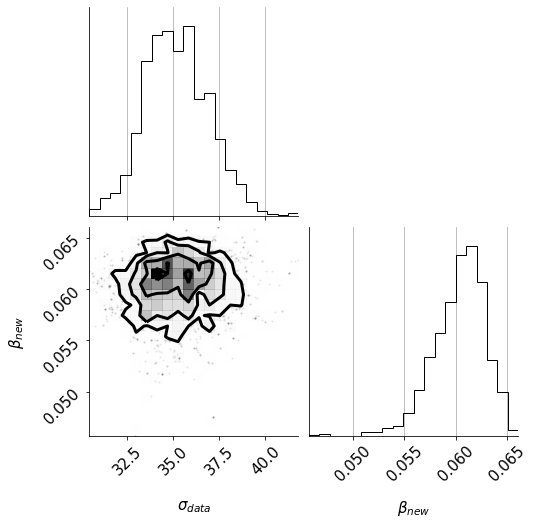

In [64]:
import corner

fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta_{new}$']
);
fig.set_size_inches(8, 8)
plt.savefig('../results/calibration_non_spatial_deterministic/corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [65]:
# define dataset
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

<ipython-input-66-df54aaea604f>:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')


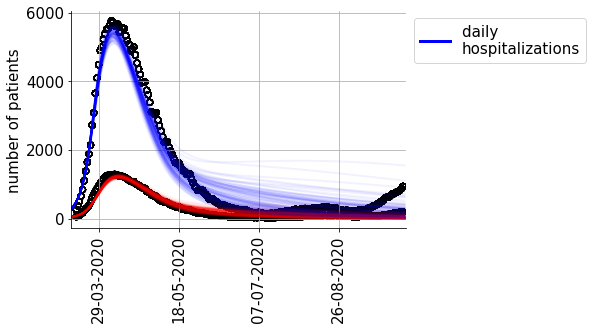

In [66]:
T = 1
start_date='15-03-2020'
#data=[df_sciensano["H_in"].values[:]]

fig,ax=plt.subplots()
for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    model.parameters['beta_new'] = np.random.choice(samples_dict['beta_new'],1,replace=False)

    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,T=T,ax=ax,plt_kwargs={'linewidth': 2,'alpha': 0.05})
    
#plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][:50].size),df_sciensano["H_in"][:50], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Re-compute the basic reproduction number

In [67]:
R_0 = (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*mean*model.parameters['s']*np.sum(Nc_total,axis=1)